# Yield Curve Steepeners

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Get Data

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/CashTreasuries/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CashTreasuries\root\src")
from SyntheticSpreads import Spread

In [3]:
df = Spread().get_spread()

## Plotting Attributes

Duration Comparison (ideally duraiton neutral)

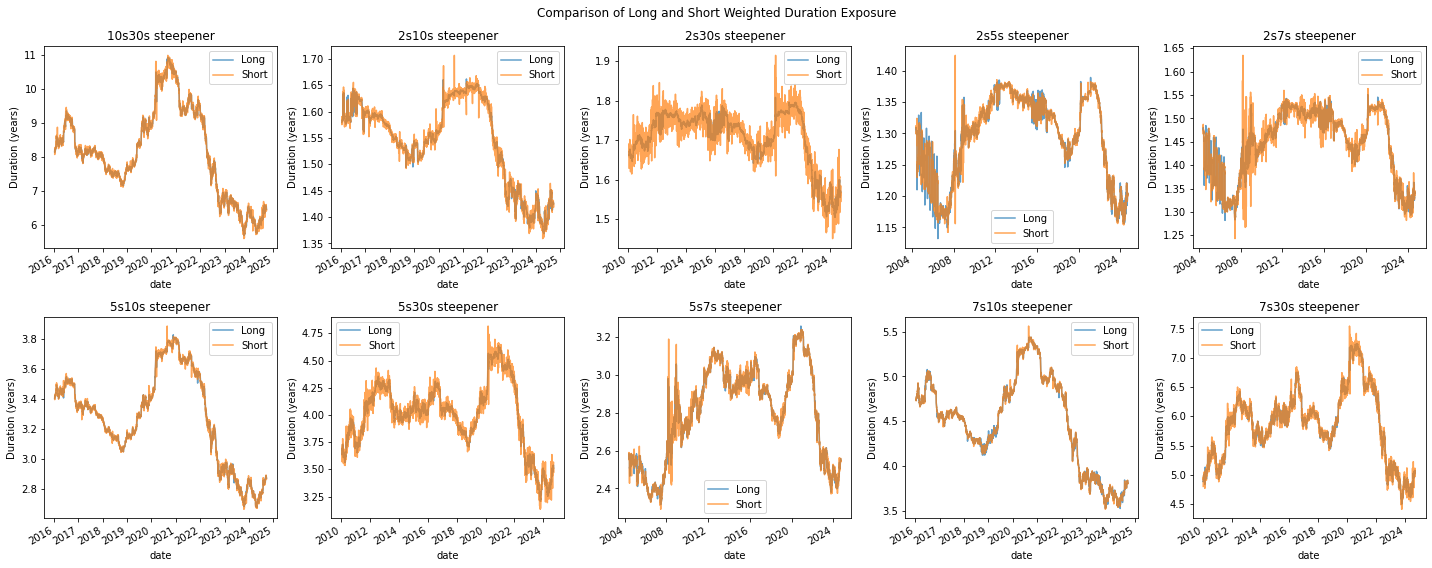

In [4]:
def plot_duration_comparison(df: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df.query(
        "var == 'duration'").
        assign(
            weighted_long  = lambda x: x.long_weight * x.long_val,
            weighted_short = lambda x: x.short_weight * x.short_val))

    steepeners = df_tmp.steepener.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(steepeners) // 2, nrows = len(steepeners) // 5, figsize = (20,8))

    for steepener, ax in zip(steepeners, axes.flatten()):

        (df_tmp.query(
            "steepener == @steepener")
            [["date", "weighted_long", "weighted_short"]].
            melt(id_vars = "date").
            rename(columns = {"pos": ""}).
            pivot(index = "date", columns = "", values = "value").
            rename(columns = {
                "weighted_long" : "Long", 
                "weighted_short": "Short"}).
            plot(
                ax     = ax,
                title  = steepener,
                ylabel = "Duration (years)",
                alpha  = 0.7))

    fig.suptitle("Comparison of Long and Short Weighted Duration Exposure")
    plt.tight_layout()
    
plot_duration_comparison(df)

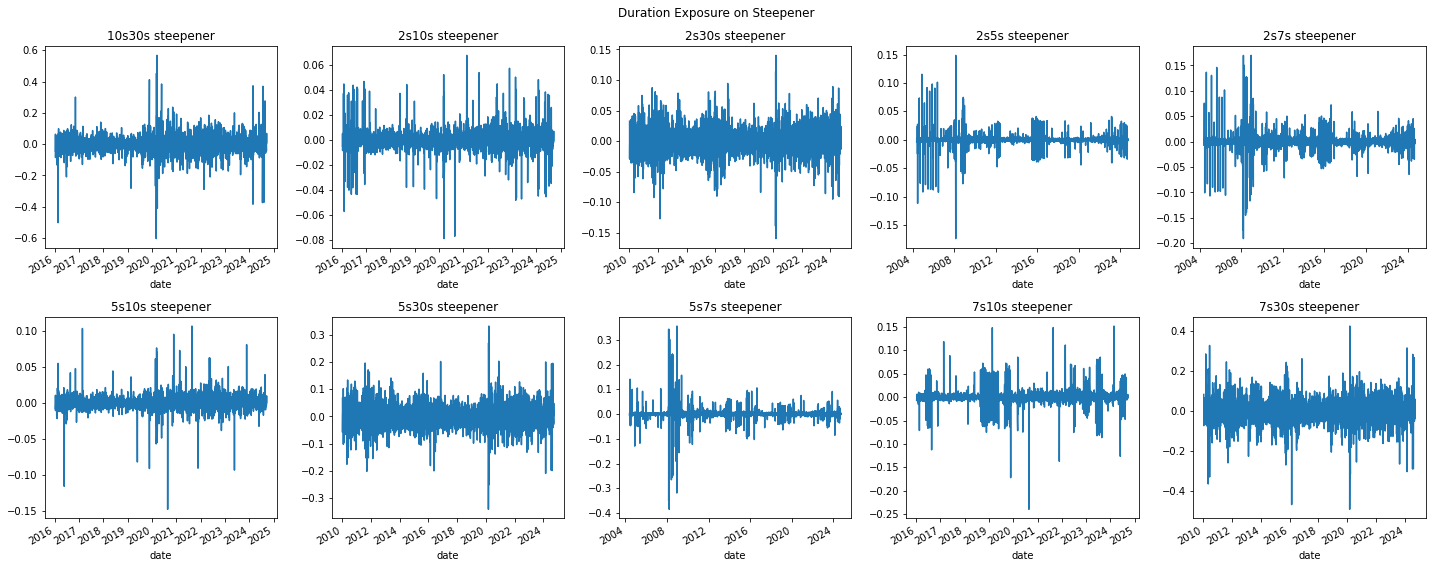

In [5]:
def plot_duration_exposure(df: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df.query(
        "var == 'duration'").
        assign(duration_exposure = lambda x: (x.long_weight * x.long_val) - (x.short_weight * x.short_val)))

    steepeners = df_tmp.steepener.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(steepeners) // 2, nrows = len(steepeners) // 5, figsize = (20,8))

    for steepener, ax in zip(steepeners, axes.flatten()):

        (df_tmp.query(
            "steepener == @steepener").
            set_index("date")
            [["duration_exposure"]].
            plot(
                ax     = ax,
                title  = steepener,
                legend = False))

    fig.suptitle("Duration Exposure on Steepener")
    plt.tight_layout()
    
plot_duration_exposure(df)

## Plotting Return

Return Comparison

In [6]:
def get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_rtn = (df.query(
        "var == 'bnd_rtn'").
        assign(
            long_rtn  = lambda x: x.long_weight * x.long_val,
            short_rtn = lambda x: x.short_weight * x.short_val)
        [["date", "long_rtn", "short_rtn", "steepener"]])
    
    return df_rtn

df_rtn = get_rtn(df)

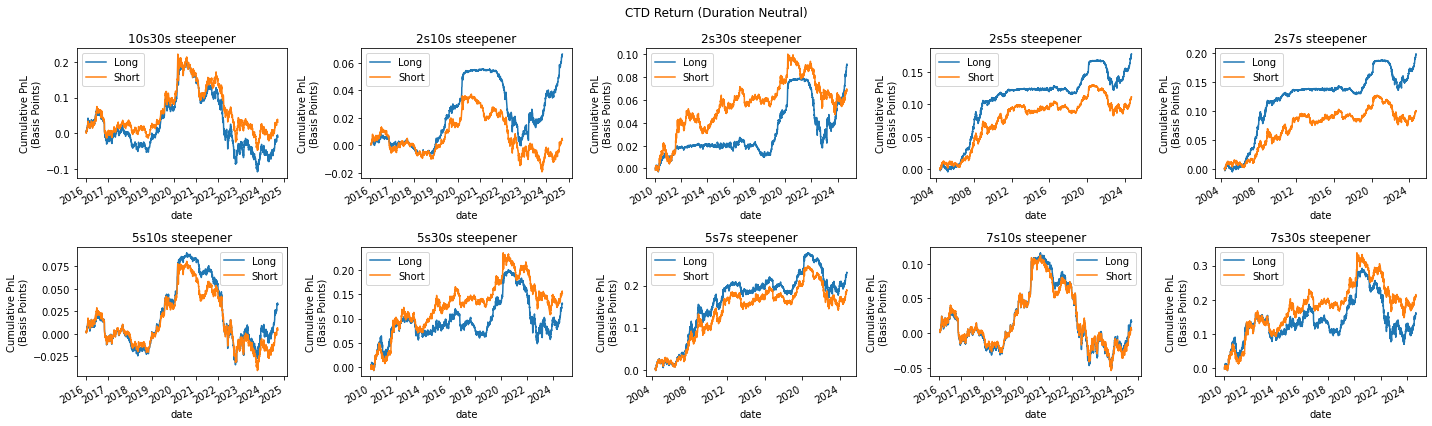

In [9]:
def plot_return_comparison(df_rtn: pd.DataFrame) -> plt.Figure:
    
    steepeners = df_rtn.steepener.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(steepeners) // 2, nrows = len(steepeners) // 5, figsize = (20,6))

    for steepener, ax in zip(steepeners, axes.flatten()): 

        (df_rtn.query(
            "steepener == @steepener").
            drop(columns = ["steepener"]).
            melt(id_vars = "date").
            assign(pos = lambda x: x.pos.str.split("_").str[0].str.capitalize()).
            rename(columns = {"pos": ""}).
            pivot(index = "date", columns = "", values = "value").
            cumsum().
            plot(
                ax     = ax,
                title  = steepener,
                ylabel = "Cumulative PnL\n(Basis Points)"))

    fig.suptitle("CTD Return (Duration Neutral)")
    plt.tight_layout()
    
plot_return_comparison(df_rtn)

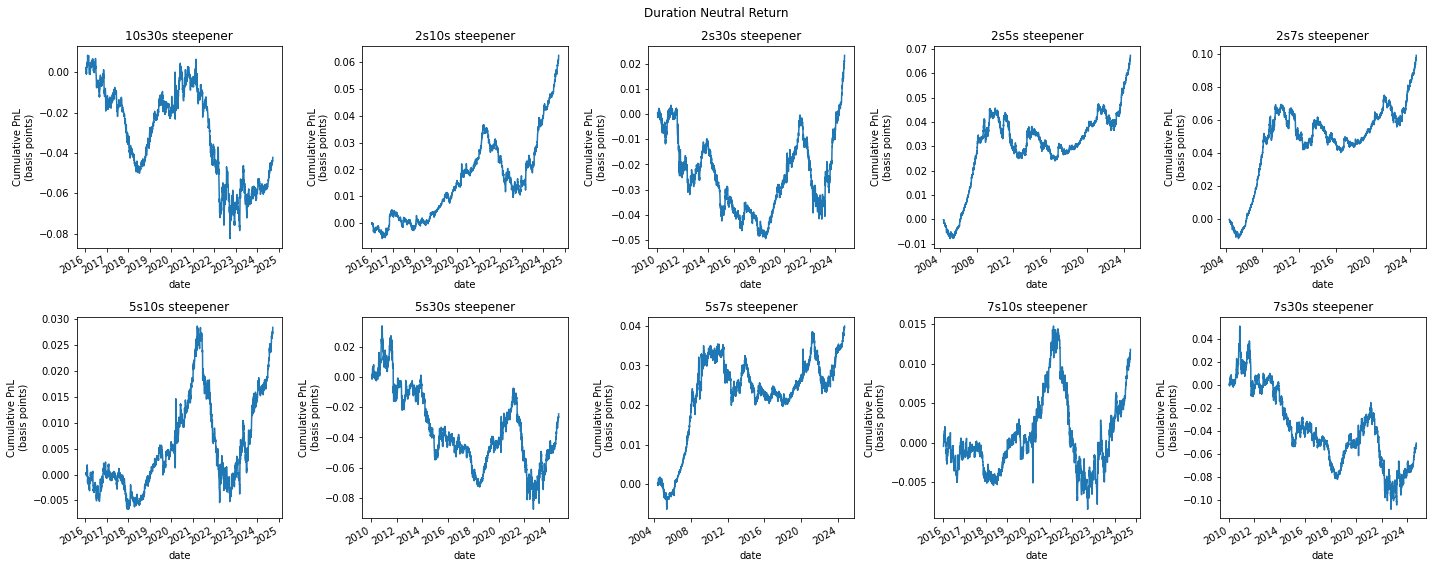

In [8]:
def plot_return(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    df_spread = (df_rtn.assign(
        spread_rtn = lambda x: x.long_rtn - x.short_rtn))

    steepeners = df_rtn.steepener.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(steepeners) // 2, nrows = len(steepeners) // 5, figsize = (20,8))

    for steepener, ax in zip(steepeners, axes.flatten()): 

        (df_spread.query(
            "steepener == @steepener").
            set_index("date")
            [["spread_rtn"]].
            cumsum().
            plot(
                ax     = ax,
                legend = False,
                title  = steepener,
                ylabel = "Cumulative PnL\n(basis points)"))

    fig.suptitle("Duration Neutral Return")
    plt.tight_layout()
    
plot_return(df_rtn)